In [8]:
import os
import re
import csv
import time
import math
import json
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import scipy.sparse as sp
import torch.nn.functional as F
import torch.optim as optim
from math import log
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from IPython.display import display
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
EDGE = 1 # 0:d2w 1:d2w+w2w 2:d2w+w2w+d2d
NODE = 0 # 0:one-hot #1:BERT
NUM_LAYERS = 2
graph_window_sizes = 20
HIDDEN_DIM = 200
DROP_OUT = 0.3  #DROP_OUT = 0.5
LR = 0.01  #LR = 0.01 for cs data
WEIGHT_DECAY = 0
EARLY_STOPPING = 145  # EARLY_STOPPING = 10
NUM_EPOCHS = 200
dataset = ["arXiv", "DBLP", "Elsevier", "PubMed"]
dataset_index = dataset[0] # Save the file name with index value

In [1]:
# Load the JSON data from file
file_path = "C:/Users/romeo/AAAI'25/citation_datasets\arXiv_citation_dataset.json"  
with open(file_path, "r", encoding="utf-8") as file:
    scholar_data = json.load(file)

OSError: [Errno 22] Invalid argument: "C:/Users/romeo/AAAI'25/citation_datasets\x07rXiv_citation_dataset.json"

## Making cited_by paper direct cite the main paper

In [9]:
# Initialize overall graph data
all_nodes = []
all_edges = []
all_titles_lists = []
all_abstracts = {}

# Loop through each main article
for idx, main_entry in enumerate(scholar_data):
    # Construct main abstract node
    main_abstract = f"Main_{idx+1}: " + main_entry["original_csv_abstract"]
    all_nodes.append(main_abstract)
    all_abstracts[main_abstract] = main_entry["original_csv_abstract"]

    # Loop through citing articles
    citing_articles = main_entry.get("citing_articles", [])
    for i, article in enumerate(citing_articles):
        node_abstract = f"Cite_{idx+1}_{i+1}: {article['abstract']}"
        all_nodes.append(node_abstract)
        all_edges.append((node_abstract, main_abstract))  # Citing -> Main
        all_abstracts[node_abstract] = article["abstract"]


print(f"Total main articles: {len(scholar_data)}")
print(f"Total citing articles: {len(node_abstract)}")
print(f"Total nodes: {len(all_nodes)}")
print(f"Total edges: {len(all_edges)}")


# Save as JSON
output_data = {
    "nodes": all_nodes,
    "edges": all_edges,
    "all_abstracts": all_abstracts,
    "titles": all_titles_lists,
}

#Set output path
output_dir = r"C:/Users/romeo/AAAI'25/citation_corpus" 
output_filename = f"{dataset[dataset_index]}.json"
output_path = os.path.join(output_dir, output_filename)

# Save JSON
try:
    os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, ensure_ascii=False, indent=4)
    print(f"\n✅ All data saved to: {output_path}")
except Exception as e:
    print(f"❌ Error saving data to JSON file: {e}")


# with open("graph_representation_all.json", "w", encoding="utf-8") as f:
#     json.dump(output_data, f, ensure_ascii=False, indent=4)

print("Graph data written to graph_representation_all.json")


Total main articles: 101
Total citing articles: 435
Total nodes: 647
Total edges: 546

✅ All data saved to: C:/Users/romeo/AAAI'25/citation_corpus\arXiv_citation_graph.json
Graph data written to graph_representation_all.json


## Extract Title

In [10]:
all_titles_lists = []
for entry in scholar_data:
    all_titles_lists.append(entry["original_csv_title"])
    all_titles_lists.extend(cit["title"] for cit in entry.get("citing_articles", []))

print("All titles:", len(all_titles_lists))

#Set output path
output_dir = r"C:\Users\romeo\AAAI'25\label_data\raw_title"
output_filename = f"{dataset[dataset_index]}.json"
output_path = os.path.join(output_dir, output_filename)

# Save JSON
try:
    os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump({"titles": all_titles_lists}, f, ensure_ascii=False, indent=4)
    print(f"\n✅ All data saved to{dataset[dataset_index]}: {output_path}")
except Exception as e:
    print(f"❌ Error saving data to JSON file: {e}")

All titles: 647


In [11]:
import nltk
import re
from textblob import Word
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')


lm = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
remove_limit = 5


def clean_str(string):
    """
    Clean and normalize a given string by removing unwanted characters,
    normalizing contractions, removing stopwords, abbreviations, and applying lemmatization and singularization.
    """
    if not isinstance(string, str):
        return ""
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    custom_stop_words = {"paper", "research", "study", "approach", "propose"}  # Custom words to remove
    abbreviations = {"e.g.": "for example", "i.e.": "that is", "etc.": "and so on", "vs.": "versus", "approx.": "approximately"}  # Abbreviations to remove

    # Replace abbreviations
    for abbr, replacement in abbreviations.items():
        string = string.replace(abbr, replacement)
    # Remove URLs
    string = re.sub(r'http\S+|www\S+', '', string)
    # Remove digits
    string = re.sub(r'[0-9]+', '', string)
    # Remove hyphens and replace with space
    string = re.sub(r'-', ' ', string)
    # Remove punctuation
    string = re.sub(r'[^A-Za-z\s]', '', string)
    # Normalize contractions
    string = re.sub(r"\'s", " is", string)
    string = re.sub(r"\'ve", " have", string)
    string = re.sub(r"n\'t", " not", string)
    string = re.sub(r"\'re", " are", string)
    string = re.sub(r"\'d", " would", string)
    string = re.sub(r"\'ll", " will", string)
    # Remove extra spaces
    string = re.sub(r'\s{2,}', ' ', string)
    # Tokenize text
    words = nltk.word_tokenize(string)
    # Remove stopwords and punctuation
    words = [word.lower() for word in words if word.lower() not in stop_words and word.lower() not in custom_stop_words and word.lower() not in punctuation]
    # Part-of-Speech tagging and filtering nouns
    tagged_list = nltk.pos_tag(words)
    nouns_list = [t[0] for t in tagged_list if t[-1] == 'NN']
    # Singularize and lemmatize words
    words = [Word(word).singularize() for word in nouns_list]
    words = [lemmatizer.lemmatize(word, pos='n') for word in words]

    return " ".join(words).strip().lower()


# ------------------------------------------------------------------------------
# 5. Build word frequency over all abstracts
# ------------------------------------------------------------------------------
original_word_freq = {}
sentences = list(all_abstracts.values())
# Create a list of all input sentences
random.seed(42)
random.shuffle(sentences)
train_input = int(0.8 * len(sentences))
train_size = sentences[:train_input]
test_size = sentences[train_input:]

print(len(train_size))
print(len(test_size))

for s in sentences:
    cleaned = clean_str(s)
    for w in cleaned.split():
        original_word_freq[w] = original_word_freq.get(w, 0) + 1
# ------------------------------------------------------------------------------
# 6. Tokenize, filter stopwords & rare words, and build vocabulary
# ------------------------------------------------------------------------------
tokenize_sentences = []
word_list_dict = {}

for s in sentences:
    cleaned    = clean_str(s)
    words      = cleaned.split()
    filtered   = []
    for w in words:
        if (w not in stop_words) and (original_word_freq.get(w, 0) >= remove_limit):
            filtered.append(w)
            word_list_dict[w] = word_list_dict.get(w, 0)  # just to collect unique words
    tokenize_sentences.append(filtered)

word_list   = list(word_list_dict.keys())
vocab_length  = len(word_list)
print("Vocabulary size:", vocab_length)

# ------------------------------------------------------------------------------
# 7. Map words to IDs and convert sentences to sequences
# ------------------------------------------------------------------------------
word_id_map = {w: i+1 for i, w in enumerate(word_list)}
print(word_id_map)
# reserve index 0 for padding

# # sequences = [
# #     [word_id_map[w] for w in doc]
# #     for doc in tokenize_sentences
# # ]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romeo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\romeo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\romeo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\romeo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\romeo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\romeo\AppData\Roaming\nltk_dat

517
130
Vocabulary size: 1024
{'hole': 1, 'vacuum': 2, 'environment': 3, 'influence': 4, 'waveform': 5, 'wave': 6, 'analysi': 7, 'work': 8, 'focu': 9, 'generation': 10, 'evolution': 11, 'type': 12, 'center': 13, 'gc': 14, 'region': 15, 'smbh': 16, 'hypervelocity': 17, 'star': 18, 'counterpart': 19, 'orbit': 20, 'hvs': 21, 'escape': 22, 'speed': 23, 'halo': 24, 'distribution': 25, 'velocity': 26, 'merger': 27, 'way': 28, 'galaxy': 29, 'change': 30, 'hv': 31, 'ejection': 32, 'scenario': 33, 'formation': 34, 'cluster': 35, 'size': 36, 'quantization': 37, 'relativity': 38, 'tegr': 39, 'space': 40, 'time': 41, 'formulation': 42, 'equation': 43, 'theory': 44, 'treatment': 45, 'operator': 46, 'number': 47, 'term': 48, 'hamiltonian': 49, 'value': 50, 'existence': 51, 'multus': 52, 'flavor': 53, 'conversion': 54, 'neutrino': 55, 'emission': 56, 'angle': 57, 'accretion': 58, 'toru': 59, 'geometry': 60, 'neutron': 61, 'occurrence': 62, 'direction': 63, 'production': 64, 'density': 65, 'parameter'

In [12]:
# from sklearn.preprocessing import MultiLabelBinarizer

# def filter_and_tokenize_titles(titles, stop_words, word_freq, freq_threshold):
#     cleaned_titles = []
#     for raw in titles:
#         # 1) Clean the string and split into tokens
#         tokens = clean_str(raw).split()
#         # 2) Filter out stopwords and low‐frequency tokens
#         filtered = [
#             tok for tok in tokens
#             if tok not in stop_words and word_freq.get(tok, 0) >= freq_threshold
#         ]
#         cleaned_titles.append(filtered)
#     return cleaned_titles

# #Usage example:
# #Assuming all_titles_lists, stop_words, original_word_freq, remove_limit are defined
# clean_title = filter_and_tokenize_titles(
#     all_titles_lists,
#     stop_words=stop_words,
#     word_freq=original_word_freq,
#     freq_threshold=remove_limit
# )

# print(clean_title[:10])
# # # # Display the cleaned abstracts
# # # paper = list(all_abstracts.values())
# # # print(paper)
# # # clean_abstract = filter_and_tokenize_titles( # Fixed typo: filter_and_tokenize_titles
# # #     paper,
# # #     stop_words=stop_words,
# # #     word_freq=original_word_freq,
# # #     freq_threshold=remove_limit
# # # )

# # print(clean_title[:10])
# # #print(clean_abstract[:2])


# # # 2) Fit the MultiLabelBinarizer
# # mlb = MultiLabelBinarizer()
# # binary_matrix = mlb.fit_transform(four_per_title)

# # # 3) Create a DataFrame for readability
# # df_labels = pd.DataFrame(binary_matrix, columns=mlb.classes_)

# # print("Classes (columns):", mlb.classes_)
# # print("\nMultilabel indicator matrix:")
# # print(df_labels)




In [13]:
# # 1) Your existing filter function
# def filter_and_tokenize_titles(titles, stop_words, word_freq, freq_threshold):
#     cleaned_titles = []
#     for raw in titles:
#         tokens = clean_str(raw).split()
#         filtered = [
#             tok for tok in tokens
#             if tok not in stop_words and word_freq.get(tok, 0) >= freq_threshold
#         ]
#         cleaned_titles.append(filtered)
#     return cleaned_titles

# # 2) Truncation/padding helper
# def pick_k_tokens(token_lists, k=4, pad_token=""):
#     """
#     From each list in token_lists, take the first k tokens.
#     If a list has fewer than k tokens, pad with pad_token.
#     """
#     out = []
#     for toks in token_lists:
#         # take first k
#         picked = toks[:k]
#         # if shorter, pad
#         if len(picked) < k:
#             picked += [pad_token] * (k - len(picked))
#         out.append(picked)
#     return out

# # 3) Run them in sequence
# clean_title = filter_and_tokenize_titles(
#     all_titles_lists,
#     stop_words=stop_words,
#     word_freq=original_word_freq,
#     freq_threshold=remove_limit
# )

# # now pick exactly 4 tokens per title
# four_per_title = pick_k_tokens(clean_title, k=4, pad_token="")

# print(four_per_title)


# # 2) Fit the MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# doc_labels = mlb.fit_transform(four_per_title)

# labels = doc_labels.flatten().tolist()
# labels = torch.LongTensor(labels).to(device)

# print(labels)

# # 3) Create a DataFrame for readability
# # labels = pd.DataFrame(binary_matrix, columns=mlb.classes_)

# # # print("Classes (columns):", mlb.classes_)
# # # print("\nMultilabel indicator matrix:")
# # print(labels)



In [14]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# … assume you already ran:
#   tokenize_sentences: List[List[str]]
#   all_titles_lists:   List[str]  (raw titles)
#   clean_str(), etc.

# 1) Extract top-K TF–IDF terms from titles
from sklearn.feature_extraction.text import TfidfVectorizer

K = 10
vec    = TfidfVectorizer(stop_words="english")
tfidf  = vec.fit_transform([ clean_str(t) for t in all_titles_lists ])
terms  = np.array(vec.get_feature_names_out())
scores = np.asarray(tfidf.sum(axis=0)).ravel()
top_terms = terms[scores.argsort()[-K:][::-1]].tolist()
print("Top-20 terms:", top_terms)


doc_labels = []

for doc in sentences:
    label = []
    for term in top_terms:
        if term in doc:
            label.append(1)
        else:
            label.append(0)
    doc_labels.append(label)


print("doc_labels:", len(doc_labels))
print(doc_labels[:5])

print("Labels:", doc_labels[:10])

# 3) Train/test split
train_labels, test_labels = train_test_split(
    doc_labels, test_size=0.2, random_state=42
)
print("Train size:", len(train_labels), "Test size:", len(test_labels))

import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Assuming original_labels_train is a list of lists, where each inner list contains the labels for a single sample
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_labels)
test_labels = mlb.transform(test_labels)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you want to flatten the labels into a single list
labels = train_labels.flatten().tolist() + test_labels.flatten().tolist()  #CS_test=1172  #SS_test =1023
labels = torch.LongTensor(labels).to(device)

Top-20 terms: ['field', 'detection', 'model', 'analysi', 'quantum', 'control', 'theory', 'learning', 'image', 'phase']
doc_labels: 647
[[0, 0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]
Labels: [[0, 0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]
Train size: 517 Test size: 130


In [15]:
# # Convert titles to a list of lists


# from sklearn.feature_extraction.text import TfidfVectorizer
# import pandas as pd

# def top_k_tfidf_per_paper(all_title_lists, k=5):
#     flat = [t for titles in all_title_lists for t in titles]
#     vec  = TfidfVectorizer(stop_words="english")
#     M    = vec.fit_transform(flat).toarray()
#     names = vec.get_feature_names_out()

#     rows = []
#     pos  = 0
#     for idx, titles in enumerate(all_title_lists):
#         n    = len(titles)
#         mat  = M[pos:pos+n]
#         avg  = mat.mean(axis=0)
#         topi = avg.argsort()[-k:][::-1]
#         raw_kws = [names[i] for i in topi]
#         # clean each keyword
#         clean_kws = [clean_str(kw) for kw in raw_kws]
#         rows.append({"paper_index":idx, "keywords_list":clean_kws})
#         pos += n

#     return pd.DataFrame(rows)

# top_k_keywords = top_k_tfidf_per_paper(all_titles_lists, k=5)
# # Now len(top_k_keywords) == 5
# print(top_k_keywords)





## Label

In [16]:
# Helper: if x is a list (or any sequence), use its length; otherwise assume it’s already an int
def to_int(x):
    try:
        return len(x)
    except TypeError:
        return x

train_n = to_int(train_size)
test_n  = to_int(test_size)

node_size = train_n + vocab_length + test_n
print("node_size:", node_size)

node_size: 1671


In [17]:
row, col, weight = [], [], []

## PMI

In [18]:
# ------------------------------------------------------------------------------
if 'train_size' not in globals():
    raise NameError("You must define `train_size` (int or list) before this block.")

if isinstance(train_size, list):
    train_size_int = len(train_size)
elif isinstance(train_size, int):
    train_size_int = train_size
else:
    raise TypeError(f"`train_size` must be int or list, got {type(train_size)}")

# ------------------------------------------------------------------------------
# 1) Sliding‐window co‐occurrence setup
# ------------------------------------------------------------------------------
window_size = graph_window_sizes   # must be an int
total_W      = 0
word_occurrence      = {}
word_pair_occurrence = {}


def ordered_word_pair(a, b):
    return (b, a) if a > b else (a, b)

def update_word_and_word_pair_occurrence(ids):
    unique_ids = set(ids)
    for wid in unique_ids:
        word_occurrence[wid] = word_occurrence.get(wid, 0) + 1
    uid_list = list(unique_ids)
    for i in range(len(uid_list)):
        for j in range(i+1, len(uid_list)):
            w1, w2 = ordered_word_pair(uid_list[i], uid_list[j])
            pair = (w1, w2)
            word_pair_occurrence[pair] = word_pair_occurrence.get(pair, 0) + 1

# ------------------------------------------------------------------------------
# 2) Build co‐occurrences via sliding window
# ------------------------------------------------------------------------------
for doc_ids in tqdm(tokenize_sentences, desc="Processing documents"):
    ids = [word_id_map[w] for w in doc_ids]
    window = ids[:window_size]
    total_W += 1
    update_word_and_word_pair_occurrence(window)

    for idx in range(window_size, len(ids)):
        window.pop(0)
        window.append(ids[idx])
        total_W += 1
        update_word_and_word_pair_occurrence(window)

# ------------------------------------------------------------------------------
# 3) Compute positive PMI and populate edge lists
# ------------------------------------------------------------------------------
for (i, j), count in word_pair_occurrence.items():
    freq_i = word_occurrence[i]
    freq_j = word_occurrence[j]
    pmi = math.log((count * total_W) / (freq_i * freq_j))
    if pmi > 0:
        # offset by train_size_int, add both directions
        row.append(train_size_int + i)
        col.append(train_size_int + j)
        weight.append(pmi)
        row.append(train_size_int + j)
        col.append(train_size_int + i)
        weight.append(pmi)

print(f"Built graph edges: {len(weight)} entries")

Processing documents:   0%|          | 0/647 [00:00<?, ?it/s]

Built graph edges: 122796 entries


## TF_IDF

In [19]:
# 1. Build inverted index: word -> list of document indices
word_doc_list = {word: [] for word in word_list}
for doc_idx, tokens in enumerate(tokenize_sentences):
    for word in set(tokens):
        word_doc_list[word].append(doc_idx)

# 2. Document Frequency (DF)
word_doc_freq = {word: len(docs) for word, docs in word_doc_list.items()}

# 3. Term Frequency (TF): mapping (doc_idx, word_id) -> frequency
doc_word_freq = {}
for doc_idx, tokens in enumerate(tokenize_sentences):
    for word in tokens:
        wid = word_id_map[word]
        key = (doc_idx, wid)
        doc_word_freq[key] = doc_word_freq.get(key, 0) + 1

# 4. Populate adjacency lists with TF-IDF weights
for doc_idx, tokens in enumerate(tokenize_sentences):
    seen = set()
    for word in tokens:
        if word in seen:
            continue
        wid = word_id_map[word]
        tf = doc_word_freq[(doc_idx, wid)]
        df = word_doc_freq[word]
        idf = math.log(len(tokenize_sentences) / df)
        weight_val = tf * idf

        # determine row index using train_size_int
        row_idx = doc_idx if doc_idx < train_size_int else doc_idx + vocab_length
        col_idx = train_size_int + wid

        row.append(row_idx)
        col.append(col_idx)
        weight.append(weight_val)

        seen.add(word)

print(f"TF-IDF edges added: {len(weight)} entries")

TF-IDF edges added: 136177 entries


## Citation Calculation (C_pp Method)

In [20]:

# 0) Convert train_size/test_size to ints (as before)
train_n = len(train_size) if isinstance(train_size, list) else train_size
test_n  = len(test_size)  if isinstance(test_size, list)  else test_size
node_size = train_n + vocab_length + test_n

# 1) Clean your edges into simple ID pairs
clean_edges = []
for src, tgt in all_edges:
    cited_by = src.split(":",1)[0].strip()
    main     = tgt.split(":",1)[0].strip()
    clean_edges.append((cited_by, main))

# 2) Build counts and out‐degrees
C, out_deg = {}, {}
for cited_by, main in clean_edges:
    C[(main, cited_by)] = C.get((main, cited_by), 0) + 1
    out_deg[cited_by]   = out_deg.get(cited_by, 0) + 1

# 3) Build the node_index over ALL document nodes (Main and Cite)
all_doc_ids = sorted({nid for pair in clean_edges for nid in pair})
node_index  = {nid: idx for idx, nid in enumerate(all_doc_ids)}

# 4) Now build your row/col/weight lists using integer indices
#rows, cols, weight = [], [], []
for (main, cited_by), cnt in C.items():
    i = node_index[cited_by]         # integer for source
    j = node_index[main]             # integer for target
    w = cnt / out_deg[cited_by]      # normalized weight
    row.append(i)
    col.append(j)
    weight.append(w)

## Build Adjacency Matrix

In [21]:
# 6) Build the full adjacency with the correct shape
adj = sp.csr_matrix((weight, (row, col)), shape=(node_size, node_size))

print("node_size:", node_size)
print("adjacency shape:", adj.shape)
print(adj)

node_size: 1671
adjacency shape: (1671, 1671)
  (0, 518)	3.4278238567774775
  (0, 519)	10.747468011665582
  (0, 520)	3.1765094284965714
  (0, 521)	3.5279073153344602
  (0, 522)	4.8629083820668
  (0, 523)	3.833288964885642
  (0, 524)	1.7809984122717568
  (0, 525)	2.1548581809645904
  (0, 526)	3.4766140209469096
  (0, 527)	2.4650131092684298
  (0, 528)	3.2942924641529547
  (0, 548)	1.0
  (1, 518)	6.855647713554955
  (1, 529)	9.420425352977091
  (1, 530)	4.07445102170253
  (1, 531)	10.17210386676202
  (1, 532)	3.2142497564794184
  (1, 533)	10.17210386676202
  (1, 534)	4.8629083820668
  (1, 535)	7.0558146306689205
  (1, 536)	4.6805868252728455
  (1, 537)	4.392904752821065
  (1, 538)	9.052872290891175
  (1, 539)	5.08605193338101
  (1, 540)	3.4766140209469096
  :	:
  (1668, 1195)	5.373734005832791
  (1668, 1229)	4.392904752821065
  (1668, 1302)	4.07445102170253
  (1668, 1311)	8.550243434329362
  (1668, 1319)	4.07445102170253
  (1668, 1336)	4.6805868252728455
  (1668, 1359)	5.08605193338101
 

In [22]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    # D^{-1/2} A D^{-1/2}
    return (
        adj.dot(d_mat_inv_sqrt)
           .transpose()
           .dot(d_mat_inv_sqrt)
           .tocoo(),
        d_inv_sqrt
    )

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape).to(device)

# Assume `adj` is your scipy CSR of size (node_size, node_size)
adj, norm_factors = normalize_adj(adj + sp.eye(adj.shape[0]))
adj = sparse_mx_to_torch_sparse_tensor(adj)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_35888\4011746467.py:25: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(indices, values, shape).to(device)


In [23]:
if NODE == 0:
    features = np.arange(node_size)
    features = torch.FloatTensor(features).to(device)
else:

    from flair.embeddings import TransformerDocumentEmbeddings, TransformerWordEmbeddings
    from flair.data import Sentence
    doc_embedding = TransformerDocumentEmbeddings('bert-base-uncased', fine_tune=False)
    word_embedding = TransformerWordEmbeddings('bert-base-uncased', layers='-1',subtoken_pooling="mean")

    sent_embs = []
    word_embs = {}

    for ind in tqdm(range(train_size+test_size)):
        sent = tokenize_sentences[ind]
        sentence = Sentence(" ".join(sent[:512]),use_tokenizer=False)
        doc_embedding.embed(sentence)
        sent_embs.append(sentence.get_embedding().tolist())
        words = Sentence(" ".join(sent[:512]),use_tokenizer=False)
        word_embedding.embed(words)
        for token in words:
            word = token.text
            embedding = token.embedding.tolist()
            if word not in word_embs:
                word_embs[word] = embedding
            else:
                word_embs[word] = np.minimum(word_embs[word], embedding)

    word_embs_list = []
    for word in word_list:
        word_embs_list.append(word_embs[word])

    features = sent_embs[:train_size] + word_embs_list + sent_embs[train_size:]


    def preprocess_features(features):
        """Row-normalize feature matrix and convert to tuple representation"""
        rowsum = np.array(features.sum(1))
        r_inv = np.power(rowsum, -1).flatten()
        r_inv[np.isinf(r_inv)] = 0.
        r_mat_inv = sp.diags(r_inv)
        features = r_mat_inv.dot(features)
        return features

    features = preprocess_features(sp.csr_matrix(features)).todense()
    features = torch.FloatTensor(features).to(device)

print("Features shape:", features)

Features shape: tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.6680e+03, 1.6690e+03,
        1.6700e+03], device='cuda:0')


## GCN Layer

In [24]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features,  drop_out = 0, activation=None, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.zeros(1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters(in_features, out_features)
        self.dropout = torch.nn.Dropout(drop_out)
        self.activation =  activation

    def reset_parameters(self,in_features, out_features):
        stdv = np.sqrt(6.0/(in_features+out_features))
        # stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        # if self.bias is not None:
        #     torch.nn.init.zeros_(self.bias)
            # self.bias.data.uniform_(-stdv, stdv)


    def forward(self, input, adj, feature_less = False):
        if feature_less:
            support = self.weight
            support = self.dropout(support)
        else:
            input = self.dropout(input)
            support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            output = output + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

## GCN Model

In [25]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, n_layers = 2):
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.gc_list = []
        if n_layers >= 2:
            self.gc1 = GraphConvolution(nfeat, nhid, dropout, activation = nn.ReLU())
            self.gc_list = nn.ModuleList([GraphConvolution(nhid, nhid, dropout, activation = nn.ReLU()) for _ in range(self.n_layers-2)])
            self.gcf = GraphConvolution(nhid, nclass, dropout)
        else:
            self.gc1 = GraphConvolution(nfeat, nclass, dropout)

    def forward(self, x, adj):
        if self.n_layers>=2:
            x = self.gc1(x, adj, feature_less = True)
            for i in range(self.n_layers-2):
                x = self.gc_list[i](x,adj)
            x = self.gcf(x,adj)
        else:
            x = self.gc1(x, adj, feature_less = True)
        return x

In [26]:
def cal_accuracy(predictions,labels):
    pred = torch.argmax(predictions,-1).cpu().tolist()
    lab = labels.cpu().tolist()
    cor = 0
    for i in range(len(pred)):
        if pred[i] == lab[i]:
            cor += 1
    return cor/len(pred)

In [27]:
import torch.optim as optim

# Define num_class with the correct value
num_class = 10 # Assume you have 10 classes, replace with your actual number of classes.

criterion = nn.CrossEntropyLoss()

model = GCN(nfeat=node_size, nhid=HIDDEN_DIM, nclass=num_class, dropout=DROP_OUT,n_layers=NUM_LAYERS).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

## Training and validation Data

In [28]:
# def generate_train_val(train_pro=0.9):
#     real_train_size = int(train_pro*train_size)
#     val_size = train_size-real_train_size

#     idx_train = np.random.choice(train_size, real_train_size,replace=False)
#     idx_train.sort()
#     idx_val = []
#     pointer = 0
#     for v in range(train_size):
#         if pointer<len(idx_train) and idx_train[pointer] == v:
#             pointer +=1
#         else:
#             idx_val.append(v)
#     idx_test = range(train_size+vocab_length, node_size)
#     return idx_train, idx_val, idx_test

# idx_train, idx_val, idx_test = generate_train_val()

In [29]:
import numpy as np

# Helper to coerce to integer if it’s a list/sequence
def to_int(x):
    try:
        return len(x)
    except TypeError:
        return int(x)

def generate_train_val(train_pro=0.9):
    # 1) Make sure train_n is an integer count
    train_n = to_int(train_size)

    # 2) Compute how many in train vs val
    real_train_n = int(train_pro * train_n)
    val_n        = train_n - real_train_n

    # 3) Randomly pick train indices
    idx_train = np.random.choice(train_n, real_train_n, replace=False)
    idx_train.sort()

    # 4) The rest go to validation
    idx_val = [i for i in range(train_n) if i not in idx_train]

    # 5) Test set indices start after (train + vocab) up to node_size
    #    (coerce node_size to int as well)
    total_nodes = to_int(node_size)
    test_start  = train_n + vocab_length
    idx_test    = list(range(test_start, total_nodes))

    return idx_train.tolist(), idx_val, idx_test

# Usage
idx_train, idx_val, idx_test = generate_train_val()
print(len(idx_train), len(idx_val), len(idx_test))


465 52 130


## Model Training

In [30]:
!pip install torch_geometric

In [31]:
import time
import csv
import torch

def train_model(show_result = True):
    val_loss = []
    train_loss = [] # List to store training losses
    train_acc = []  # List to store training accuracies
    val_acc = []    # List to store validation accuracies

    # Ensure labels are on the correct device
    labels_tensor = labels.to(device)  # Move labels to the desired device if needed
    #If labels is already a CUDA tensor, this line will have no effect, but won't cause harm either.
    # If labels is a CPU tensor, it will be moved to the GPU.

    for epoch in range(NUM_EPOCHS):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        output= model(features, adj)
        loss_train_epoch = criterion(output[idx_train], labels_tensor[idx_train])
        acc_train_epoch = cal_accuracy(output[idx_train], labels_tensor[idx_train])
        loss_train_epoch.backward()
        optimizer.step()

        # Store training loss and accuracy for this epoch
        train_loss.append(loss_train_epoch.item())
        train_acc.append(acc_train_epoch)

        model.eval()
        output = model(features, adj)

        loss_val_epoch = criterion(output[idx_val], labels_tensor[idx_val])
        val_loss.append(loss_val_epoch.item())
        acc_val_epoch = cal_accuracy(output[idx_val], labels_tensor[idx_val])

        # Store validation accuracy for this epoch
        val_acc.append(acc_val_epoch)

        if show_result:
            print(  'Epoch: {:04d}'.format(epoch+1),
                    'loss_train: {:.4f}'.format(loss_train_epoch.item()),
                    'acc_train: {:.4f}'.format(acc_train_epoch),
                    'loss_val: {:.4f}'.format(loss_val_epoch.item()),
                    'acc_val: {:.4f}'.format(acc_val_epoch),
                    'time: {:.4f}s'.format(time.time() - t))

        if epoch > EARLY_STOPPING and np.min(val_loss[-EARLY_STOPPING:]) > np.min(val_loss[:-EARLY_STOPPING]) :
            if show_result:
                print("Early Stopping...")
            break

    return train_loss, train_acc, val_loss, val_acc # Return the collected metrics

# Call train_model and store the returned metrics
loss_train, acc_train, loss_val, acc_val = train_model()

Epoch: 0001 loss_train: 2.3026 acc_train: 0.0516 loss_val: 2.2843 acc_val: 0.9231 time: 0.1319s
Epoch: 0002 loss_train: 2.2851 acc_train: 0.9183 loss_val: 2.2658 acc_val: 0.9231 time: 0.0062s
Epoch: 0003 loss_train: 2.2675 acc_train: 0.9183 loss_val: 2.2468 acc_val: 0.9231 time: 0.0055s
Epoch: 0004 loss_train: 2.2496 acc_train: 0.9183 loss_val: 2.2271 acc_val: 0.9231 time: 0.0040s
Epoch: 0005 loss_train: 2.2312 acc_train: 0.9183 loss_val: 2.2069 acc_val: 0.9231 time: 0.0045s
Epoch: 0006 loss_train: 2.2125 acc_train: 0.9183 loss_val: 2.1862 acc_val: 0.9231 time: 0.0050s
Epoch: 0007 loss_train: 2.1935 acc_train: 0.9183 loss_val: 2.1648 acc_val: 0.9231 time: 0.0045s
Epoch: 0008 loss_train: 2.1740 acc_train: 0.9183 loss_val: 2.1430 acc_val: 0.9231 time: 0.0030s
Epoch: 0009 loss_train: 2.1544 acc_train: 0.9183 loss_val: 2.1207 acc_val: 0.9231 time: 0.0050s
Epoch: 0010 loss_train: 2.1337 acc_train: 0.9183 loss_val: 2.0979 acc_val: 0.9231 time: 0.0042s
Epoch: 0011 loss_train: 2.1134 acc_train

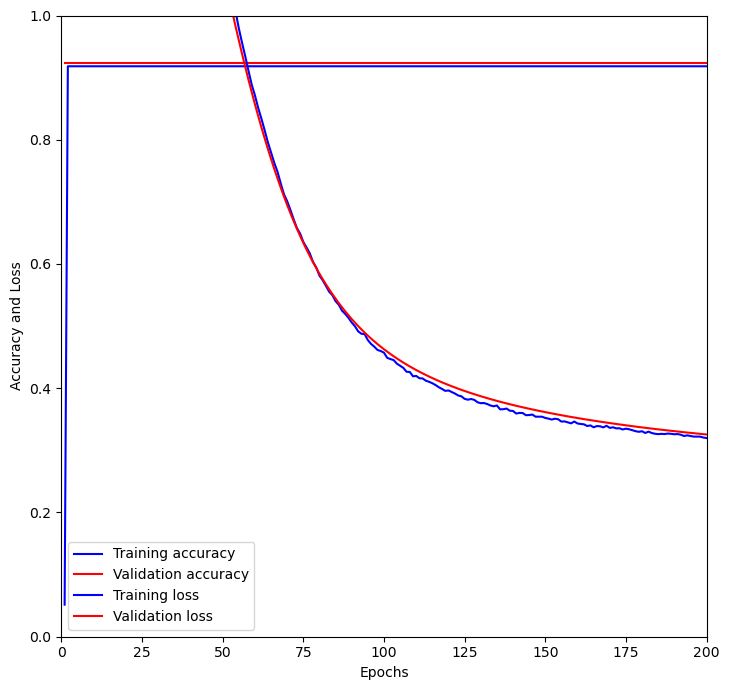

In [32]:
import matplotlib.pyplot as plt

# Plotting the metrics
epochs = list(range(1, len(loss_train) + 1))

dataset = 'CS'
plt.figure(figsize=(14, 7))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_train, 'b', label='Training accuracy')
plt.plot(epochs, acc_val, 'r', label='Validation accuracy')
plt.plot(epochs, loss_train, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and Loss')
plt.ylim(0, 1.0)
plt.xlim(0, 200)
plt.legend()

# Plot for Accuracy
# plt.subplot(1, 2, 2)

# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

plt.tight_layout()
plt.show()

## Evaluate for 10 Times Run

In [33]:
from sklearn.metrics import f1_score, accuracy_score

In [34]:
from sklearn.metrics import f1_score, accuracy_score
def test():
    model.eval()
    output = model(features, adj)
    predictions = torch.argmax(output[idx_test],-1).cpu().tolist()
    # Move test_labels to CPU and convert to NumPy array
    test_labels_np = test_labels.cpu().numpy()
    acc = accuracy_score(test_labels_np, predictions)  # Use the NumPy array
    f11 = f1_score(test_labels_np,predictions, average='macro') # Use the NumPy array
    f12 = f1_score(test_labels_np,predictions, average = 'micro') # Use the NumPy array
    f13 = f1_score(test_labels_np,predictions, average = 'weighted') # Use the NumPy array
    return acc, f11, f12, f13

#print(test())
# Call the test function and print the results
acc, f1_macro, f1_micro, f1_weighted = test()
print("Accuracy:", acc)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Weighted):", f1_weighted)
print("std:", np.std(np.array(val_loss)))

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

## Data process for LLM

In [42]:
!pip install tensorboard

   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/5.5 MB 1.6 MB/s eta 0:00:04
   --- ------------------------------------ 0.5/5.5 MB 6.0 MB/s eta 0:00:01
   ------- -------------------------------- 1.0/5.5 MB 8.0 MB/s eta 0:00:01
   ----------- ---------------------------- 1.6/5.5 MB 9.3 MB/s eta 0:00:01
   ---------------- ----------------------- 2.3/5.5 MB 11.1 MB/s eta 0:00:01
   --------------------- ------------------ 2.9/5.5 MB 11.6 MB/s eta 0:00:01
   ------------------------- -------------- 3.6/5.5 MB 11.9 MB/s eta 0:00:01
   ------------------------------ --------- 4.2/5.5 MB 12.2 MB/s eta 0:00:01
   ---------------------------------- ----- 4.8/5.5 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------  5.5/5.5 MB 12.4 MB/s eta 0:00:01
   ---------------------------------------- 5.5/5.5 MB 12.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/135.8 kB ? eta -:--:--
   --------------

In [ ]:
# print(len(all_titles_lists))
# print(len(sentences))

In [43]:
def tokenize_title_and_abstract(titles, abstracts):
    result = []
    for t, a in zip(titles, abstracts):
        t_toks = clean_str(t).split()
        a_toks = clean_str(a).split()
        result.append([t_toks, a_toks])
    return result

# Usage
all_data = tokenize_title_and_abstract(all_titles_lists, sentences)
print(all_data)

[[['similarity', 'maintenance', 'framework', 'machinery'], ['hole', 'vacuum', 'environment', 'influence', 'deformability', 'waveform', 'interpretation', 'wave', 'analysi', 'work', 'focu', 'generation', 'vacuum', 'evolution', 'deformability', 'measurability']], [['review', 'learning', 'diagnosi', 'machinery'], ['type', 'center', 'gc', 'region', 'vicinity', 'hole', 'smbh', 'type', 'hypervelocity', 'star', 'counterpart', 'orbit', 'sgr', 'type', 'hvs', 'escape', 'speed', 'halo', 'smbh', 'sgr', 'distribution', 'deficit', 'hvs', 'velocity', 'deficit', 'deficiency', 'ma', 'hole', 'imbh', 'ma', 'binary', 'merger', 'way', 'sausage', 'enceladu', 'dwarf', 'galaxy', 'recoil', 'sgr', 'velocity', 'change', 'hv', 'ejection', 'scenario', 'formation', 'star', 'cluster', 'gc', 'distribution', 'size', 'stellar']], [['intersection', 'signal', 'processing', 'machine', 'learning', 'use', 'case', 'analysi'], ['quantization', 'teleparallel', 'relativity', 'tegr', 'space', 'time', 'weyl', 'dw', 'formulation', 

In [44]:
all_train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)
train_data, valid_data = train_test_split(all_train_data, test_size=0.1, random_state=42)
print("all_train_data:", len(all_train_data), "test_data:", len(test_data))
print("train_data:", len(train_data), "valid_data:", len(valid_data))

all_train_data: 517 test_data: 130
train_data: 465 valid_data: 52


In [ ]:
# import pandas as pd
# import numpy as np
# import torch
# from sklearn.model_selection import train_test_split


# # 1) Extract top-K TF–IDF terms from titles
# from sklearn.feature_extraction.text import TfidfVectorizer

# K = 10
# vec    = TfidfVectorizer(stop_words="english")
# tfidf  = vec.fit_transform([ clean_str(t) for t in all_titles_lists ])
# terms  = np.array(vec.get_feature_names_out())
# scores = np.asarray(tfidf.sum(axis=0)).ravel()
# top_terms = terms[scores.argsort()[-K:][::-1]].tolist()
# print("Top-20 terms:", top_terms)

# title_abstract_labels = []

# for doc in all_data:
#     label = []
#     for term in top_terms:
#         if term in doc:
#             label.append(1)
#         else:
#             label.append(0)
#     title_abstract_labels.append(label)


# print("doc_labels:", len(title_abstract_labels))
# print(title_abstract_labels[:5])


# all_train_labels, test_labels = train_test_split(doc_labels, test_size=0.2, random_state=42)
# train_labels, valid_labels = train_test_split(all_train_labels, test_size=0.1, random_state=42)
# print("train_labels:", len(all_train_labels), "test_labels:", len(test_labels))
# print("train_labels:", len(train_labels), "valid_labels:", len(valid_labels))


# import numpy as np
# from sklearn.preprocessing import MultiLabelBinarizer

# # Assuming original_labels_train is a list of lists, where each inner list contains the labels for a single sample
# mlb = MultiLabelBinarizer()
# train_labels = mlb.fit_transform(train_labels)
# test_labels = mlb.transform(test_labels)

# import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Assuming you want to flatten the labels into a single list
# llm_labels = train_labels.flatten().tolist() + test_labels.flatten().tolist()  #CS_test=1172  #SS_test =1023
# llm_labels = torch.LongTensor(labels).to(device)

In [45]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_texts(data_list):
    text_list = []
    for doc_tokens in data_list:
        # doc_tokens is expected to be [title_tokens, abstract_tokens]
        if len(doc_tokens) == 2 and isinstance(doc_tokens[0], list) and isinstance(doc_tokens[1], list):
            # Join title and abstract tokens into a single string
            combined_text = " ".join(doc_tokens[0] + doc_tokens[1])
            text_list.append(combined_text)
        else:
            # Handle cases where the structure might be different, or skip
            print(f"Warning: Unexpected data structure for document: {doc_tokens}. Skipping or handling differently.")
            # Depending on expected input, you might want to raise an error or log
            pass # Or add other handling logic

    return tokenizer(
        text_list,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    )

train_encodings = preprocess_texts(train_data)
val_encodings = preprocess_texts(valid_data)
test_encodings = preprocess_texts(test_data)

print("Train encodings shape:", train_encodings['input_ids'].shape)
print("Validation encodings shape:", val_encodings['input_ids'].shape)
print("Test encodings shape:", test_encodings['input_ids'].shape)

Train encodings shape: torch.Size([465, 256])
Validation encodings shape: torch.Size([52, 111])
Test encodings shape: torch.Size([130, 117])


In [46]:
# 0) define K, top_terms, and your labeling function
K = len(top_terms)  # number of labels
assert K > 1, "You must have loaded your top_terms"

def label_documents(docs, top_terms, threshold=4):
    labels = []
    top_set = set(top_terms)
    for doc in docs:
        toks = clean_str(doc).split()
        hits = len(set(toks) & top_set)
        labels.append([1 if i<hits and i<threshold else 0 for i in range(K)])
        # ←–– adjust this line to produce an actual length-K list of 0/1s
    return labels

# 1) Build your full doc list in the same order you encoded them:
all_docs = train_data + valid_data + test_data

# 2) Generate your binary_labels list
binary_labels = label_documents(all_docs, top_terms, threshold=4)
assert len(binary_labels) == len(all_docs)

# 3) Now split exactly as your data
n_train = len(train_data)
n_val   = len(valid_data)
n_test  = len(test_data)

train_labels_split = binary_labels[0 : n_train]
val_labels_split   = binary_labels[n_train : n_train+n_val]
test_labels_split  = binary_labels[n_train+n_val : n_train+n_val+n_test]

# 4) Define your Dataset class (no change)
class SentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {
            'input_ids':      self.encodings['input_ids'][idx].to(device),
            'attention_mask': self.encodings['attention_mask'][idx].to(device),
            'labels':         torch.tensor(
                                   self.labels[idx],
                                   dtype=torch.float,
                                   device=device
                               )
        }
        return item

# 5) Finally instantiate
train_dataset = SentDataset(train_encodings, train_labels_split)
val_dataset   = SentDataset(val_encodings,   val_labels_split)
test_dataset  = SentDataset(test_encodings,  test_labels_split)

print("Train size:", len(train_dataset))
print("Val   size:", len(val_dataset))
print("Test  size:", len(test_dataset))

Train size: 465
Val   size: 52
Test  size: 130


In [47]:
# import torch
# from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# # Assuming K (number of top terms) is defined in a previous cell
# # If not, you might need to define it or get it from the label data
# # Based on cell K6qDEpow-Acl, K is set to 10.
# num_labels = K # Use the number of top TF-IDF terms as the number of labels

# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# training_args = TrainingArguments(
#     output_dir="./results",
#     eval_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     optim='adamw_torch',
#     num_train_epochs=1,
#     dataloader_pin_memory=False,
#     weight_decay=0.01,
#     max_grad_norm = 1.0,
#     warmup_ratio = 0.1,
#     logging_dir="./logs",
#     logging_steps=10,
#     lr_scheduler_type = "constant",
#     load_best_model_at_end=True,
#     save_strategy="epoch",
#     report_to = "tensorboard",
#     save_safetensors=True,
#     fp16=True,
#     seed=42 # Assuming a seed is needed, using 42 as a common practice
# )

# def compute_metrics(pred):
#     labels = pred.label_ids
#     # For multi-label classification with BCEWithLogitsLoss, predictions are logits
#     # Apply sigmoid and a threshold to get binary predictions
#     preds = (torch.sigmoid(torch.tensor(pred.predictions)) > 0.5).long().numpy()
#     # Ensure labels are also numpy for sklearn metrics
#     labels = labels.astype(np.int64)


#     # Use multi-label appropriate metrics
#     # accuracy: subset accuracy (all labels must match) or micro/macro/weighted accuracy
#     # precision, recall, f1: typically calculated with average='macro', 'micro', or 'weighted'

#     # Example using micro average for precision, recall, f1
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")
#     # For accuracy, you might want micro accuracy (same as precision/recall/f1 micro)
#     # or subset accuracy (strict match of all labels)
#     acc = accuracy_score(labels, preds) # This calculates subset accuracy by default

#     return {
#         "accuracy": acc,
#         "precision": precision,
#         "recall": recall,
#         "f1": f1,
#     }

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics,
# )
# trainer.train()

c:\Users\romeo\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.042300,0.032874,1.000000,0.000000,0.000000,0.000000


c:\Users\romeo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\romeo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\romeo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=117, training_loss=0.17559528656494924, metrics={'train_runtime': 6.858, 'train_samples_per_second': 67.804, 'train_steps_per_second': 17.06, 'total_flos': 61177714375680.0, 'train_loss': 0.17559528656494924, 'epoch': 1.0})

In [59]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import scipy.sparse as sp # Needed for sparse matrix operations in GCN

# ————————————————— Assumptions ——————————————————
# device, features, adj,
# train_encodings, val_encodings, test_encodings,
# train_labels_split, val_labels_split, test_labels_split (from SentDataset setup, already tensors)
# idx_train, idx_val, idx_test (from generate_train_val)
# LR, WEIGHT_DECAY, NUM_EPOCHS, EARLY_STOPPING, HIDDEN_DIM, NUM_LAYERS, DROP_OUT
# are defined elsewhere in your notebook and are accessible in this scope.

# Ensure encodings are on the correct device and are of type torch.LongTensor
for enc in (train_encodings, val_encodings, test_encodings):
    for k in ('input_ids', 'attention_mask'):
        if not isinstance(enc[k], torch.Tensor):
            enc[k] = torch.tensor(enc[k], dtype=torch.long)
        # Move to device
        enc[k] = enc[k].to(device)

# Determine number of labels (K should be defined from top_terms in previous cells)
try:
    num_labels = K
except NameError:
    print("Warning: K not defined, defaulting to 10 labels.")
    num_labels = 10

# Load the LLM head for sequence classification
llm_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=num_labels
).to(device)

# Multi-label binary cross-entropy with logits loss
criterion = nn.BCEWithLogitsLoss()

def calc_acc(preds, labels, thresh=0.5):
    """
    Calculates multi-label accuracy.
    Args:
        preds (torch.Tensor): Raw logits from the model.
        labels (torch.Tensor): Ground truth binary labels.
        thresh (float): Threshold to convert logits to binary predictions.
    Returns:
        float: Mean accuracy.
    """
    # Apply sigmoid to logits and then threshold to get binary predictions
    preds_bin = (torch.sigmoid(preds) > thresh).float()
    # Ensure labels are float for element-wise comparison
    if labels.dtype != torch.float:
        labels = labels.float()
    # Calculate accuracy: (correct predictions / total predictions) for each label, then mean
    return (preds_bin == labels).float().mean().item()

# --- GCN Layer Definition (Copied from your original notebook for completeness) ---
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features, drop_out=0, activation=None, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.zeros(1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters(in_features, out_features)
        self.dropout = torch.nn.Dropout(drop_out)
        self.activation = activation

    def reset_parameters(self, in_features, out_features):
        stdv = np.sqrt(6.0 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        # if self.bias is not None:
        #     torch.nn.init.zeros_(self.bias)

    def forward(self, input, adj, feature_less=False):
        if feature_less:
            support = self.weight
            support = self.dropout(support)
        else:
            input = self.dropout(input)
            support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            output = output + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

# --- GCN Model Definition (Corrected) ---
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, n_layers=2):
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.gc_list = nn.ModuleList() # Initialize as ModuleList for proper registration

        if n_layers >= 2:
            # Explicitly pass drop_out and bias arguments
            self.gc1 = GraphConvolution(nfeat, nhid, drop_out=dropout, activation=nn.ReLU(), bias=True)
            for _ in range(self.n_layers - 2):
                self.gc_list.append(GraphConvolution(nhid, nhid, drop_out=dropout, activation=nn.ReLU(), bias=True))
            self.gcf = GraphConvolution(nhid, nclass, drop_out=dropout, activation=None, bias=True) # Last layer typically no activation for classification
        else:
            self.gc1 = GraphConvolution(nfeat, nclass, drop_out=dropout, activation=None, bias=True)

    def forward(self, x, adj):
        if self.n_layers >= 2:
            # For the first layer, if features are not actual node features (e.g., just indices),
            # `feature_less=True` uses only the weight matrix.
            # If `features` are actual LLM embeddings, `feature_less` should be False.
            # Assuming 'features' are now LLM embeddings, so `feature_less` should be False.
            x = self.gc1(x, adj, feature_less=False) # Changed to False assuming LLM embeddings are real features
            for i in range(self.n_layers - 2):
                x = self.gc_list[i](x, adj)
            x = self.gcf(x, adj)
        else:
            x = self.gc1(x, adj, feature_less=False) # Changed to False
        return x

def train_combined_model(show_result=True):
    """
    Trains the combined GCN-LLM model.
    Args:
        show_result (bool): Whether to print epoch-wise training results.
    Returns:
        tuple: Lists of training combined loss, training accuracy,
               validation combined loss, and validation accuracy.
    """
    # Ensure labels for GCN training/validation are on the correct device and are float.
    # These are assumed to be already prepared as `train_labels_split` and `val_labels_split`
    # from the `SentDataset` setup (cell `of-HB7mvq7xV`), and should be `torch.float` tensors.

    # Convert lists of labels to torch.Tensor and move to device
    gcn_train_labels_for_loss = torch.tensor(train_labels_split, dtype=torch.float).to(device)
    gcn_val_labels_for_loss = torch.tensor(val_labels_split, dtype=torch.float).to(device)

    # History lists to store metrics
    history = {
        'train_combined': [], 'train_gcn': [], 'train_llm': [], 'train_acc': [],
        'val_combined': [],     'val_gcn': [],   'val_llm': [],   'val_acc': []
    }

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(NUM_EPOCHS):
        t0 = time.time() # Start time for the epoch

        # Set models to training mode
        model.train()
        llm_model.train()

        # Zero gradients for both optimizers
        optimizer_gcn.zero_grad()
        optimizer_llm.zero_grad()

        # — GCN Forward Pass —
        # The GCN processes all nodes in the graph. `features` are the node features
        # (which should include LLM embeddings for document nodes). `adj` is the adjacency matrix.
        all_gcn_logits = model(features, adj)
        # Select GCN logits corresponding to the training documents based on `idx_train`
        gcn_logits_train = all_gcn_logits[idx_train]

        # — LLM Forward Pass —
        # The LLM processes its specific training input data (`train_encodings`).
        # Note: We use the entire `train_encodings` here, not sliced by `idx_train`,
        # as `train_encodings` already represents the LLM's training set.
        llm_output_train = llm_model(input_ids=train_encodings['input_ids'],
                                     attention_mask=train_encodings['attention_mask'])
        llm_logits_train = llm_output_train.logits

        # — Loss Calculation —
        # GCN loss: uses GCN's training logits and the corresponding labels for GCN's training documents.
        loss_gcn_train = criterion(gcn_logits_train, gcn_train_labels_for_loss)
        # LLM loss: uses LLM's training logits and the corresponding labels for LLM's training data.
        # Assuming `gcn_train_labels_for_loss` is correctly aligned with `train_encodings`.
        loss_llm_train = criterion(llm_logits_train, gcn_train_labels_for_loss)

        # Combined loss for backpropagation
        loss_comb_train = loss_gcn_train + loss_llm_train
        loss_comb_train.backward() # Backpropagate combined loss

        # Optimizer steps for both models
        optimizer_gcn.step()
        optimizer_llm.step()

        # — Training Accuracy Calculation —
        # For combined accuracy, average the logits from GCN and LLM.
        # This assumes a direct correspondence between documents in `idx_train` and `train_encodings`.
        acc_train = calc_acc((gcn_logits_train + llm_logits_train) / 2, gcn_train_labels_for_loss)

        # — Validation Phase —
        # Set models to evaluation mode
        model.eval()
        llm_model.eval()

        with torch.no_grad(): # Disable gradient calculations for validation
            # GCN validation
            all_gcn_logits_val = model(features, adj)
            gcn_logits_val = all_gcn_logits_val[idx_val]

            # LLM validation
            llm_output_val = llm_model(input_ids=val_encodings['input_ids'],
                                       attention_mask=val_encodings['attention_mask'])
            llm_logits_val = llm_output_val.logits

            # Validation Losses
            loss_gcn_val = criterion(gcn_logits_val, gcn_val_labels_for_loss)
            loss_llm_val = criterion(llm_logits_val, gcn_val_labels_for_loss)
            loss_comb_val = loss_gcn_val + loss_llm_val

            # Validation Accuracy
            acc_val = calc_acc((gcn_logits_val + llm_logits_val) / 2, gcn_val_labels_for_loss)

        # — Record Metrics —
        history['train_combined'].append(loss_comb_train.item())
        history['train_gcn'].append(loss_gcn_train.item())
        history['train_llm'].append(loss_llm_train.item())
        history['train_acc'].append(acc_train)
        history['val_combined'].append(loss_comb_val.item())
        history['val_gcn'].append(loss_gcn_val.item())
        history['val_llm'].append(loss_llm_val.item())
        history['val_acc'].append(acc_val)

        # — Print Results (if show_result is True) —
        if show_result:
            print(
                f"Epoch {epoch+1:02d} | "
                f"Train ▶ Comb={loss_comb_train:.4f}, GCN={loss_gcn_train:.4f}, LLM={loss_llm_train:.4f}, Acc={acc_train:.4f} | "
                f"Val   ▶ Comb={loss_comb_val:.4f}, GCN={loss_gcn_val:.4f}, LLM={loss_llm_val:.4f}, Acc={acc_val:.4f} | "
                f"{time.time()-t0:.1f}s"
            )

        # — Early Stopping Logic —
        # Stop if validation combined loss does not improve for `EARLY_STOPPING` epochs
        if loss_comb_val.item() < best_val_loss:
            best_val_loss = loss_comb_val.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOPPING:
                if show_result: print("Early stopping triggered.")
                break

    return (
        history['train_combined'], history['train_acc'],
        history['val_combined'],   history['val_acc']
    )

# Explicitly initialize GCN model and its optimizer before training
# This ensures 'model' is the GCN instance and not overwritten by other modules.
try:
    # Validate features shape before initializing GCN
    # If features is 1D, attempt to reshape it assuming the 1D size is num_nodes
    # and we need to add a feature dimension (e.g., LLM embedding size).
    if features.ndim == 1:
        assumed_embedding_dim = 768 # Common BERT embedding dimension
        print(f"Warning: 'features' is 1D with shape {features.shape}. "
              f"Attempting to reshape to 2D assuming {features.shape[0]} nodes and an embedding dimension of {assumed_embedding_dim}. "
              f"Please ensure this assumption is correct in your data preparation steps.")
        features = features.unsqueeze(1).repeat(1, assumed_embedding_dim) # Reshape to (num_nodes, 1) and then repeat to (num_nodes, assumed_embedding_dim)
        # Alternatively, if features are meant to be one-hot for vocab nodes, and LLM for doc nodes,
        # this reshaping might not be universally applicable. The ideal fix is upstream.
    elif features.ndim != 2:
        raise ValueError(f"Expected 'features' to be a 2D tensor (num_nodes, feature_dim), but got shape {features.shape}. "
                         f"Please ensure LLM embeddings and other node features are correctly combined into a 2D tensor "
                         f"in the preceding cells (e.g., where 'combined_features' is created).")

    # Assuming GCN class is defined and accessible in the notebook context
    # and HIDDEN_DIM, NUM_LAYERS, DROP_OUT are defined.
    # 'features.shape[1]' provides the correct input feature dimension (LLM embedding dim).
    model = GCN(nfeat=features.shape[1], nhid=HIDDEN_DIM, nclass=num_labels, dropout=DROP_OUT, n_layers=NUM_LAYERS).to(device)
    optimizer_gcn = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
except NameError as e:
    print(f"Error initializing GCN model: {e}. Please ensure GCN class and all necessary variables (HIDDEN_DIM, NUM_LAYERS, DROP_OUT, features, num_labels, device) are defined and accessible.")
    raise # Re-raise to stop execution if critical variables are missing.
except ValueError as e:
    print(f"Configuration Error: {e}")
    raise # Re-raise to stop execution if features are malformed.


# Execute the training process
train_losses, train_accs, val_losses, val_accs = train_combined_model()

# Print the final results after training
print(f"Final Training Combined Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Combined Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import scipy.sparse as sp # Needed for sparse matrix operations in GCN

# ————————————————— Assumptions ——————————————————
# device, features, adj,
# doc_encodings (all document encodings, e.g., from preprocess_texts for all_nodes)
# labels (the original full labels tensor for all documents)
# idx_train, idx_val, idx_test (from generate_train_val)
# LR, WEIGHT_DECAY, NUM_EPOCHS, EARLY_STOPPING, HIDDEN_DIM, NUM_LAYERS, DROP_OUT
# BATCH_SIZE (new assumption for LLM mini-batching)
# are defined elsewhere in your notebook and are accessible in this scope.

# Ensure encodings are on the correct device and are of type torch.LongTensor
# This loop now applies to doc_encodings, as we will batch from it.
for k in ('input_ids', 'attention_mask'):
    if not isinstance(doc_encodings[k], torch.Tensor):
        doc_encodings[k] = torch.tensor(doc_encodings[k], dtype=torch.long)
    # Move to device (only once for the full dataset)
    doc_encodings[k] = doc_encodings[k].to(device)


# Determine number of labels (K should be defined from top_terms in previous cells)
try:
    num_labels = K
except NameError:
    print("Warning: K not defined, defaulting to 10 labels.")
    num_labels = 10

# Load the LLM head for sequence classification
llm_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=num_labels
).to(device)

# Multi-label binary cross-entropy with logits loss
criterion = nn.BCEWithLogitsLoss()

def calc_acc(preds, labels, thresh=0.5):
    """
    Calculates multi-label accuracy.
    Args:
        preds (torch.Tensor): Raw logits from the model.
        labels (torch.Tensor): Ground truth binary labels.
        thresh (float): Threshold to convert logits to binary predictions.
    Returns:
        float: Mean accuracy.
    """
    # Apply sigmoid to logits and then threshold to get binary predictions
    preds_bin = (torch.sigmoid(preds) > thresh).float()
    # Ensure labels are float for element-wise comparison
    if labels.dtype != torch.float:
        labels = labels.float()
    # Calculate accuracy: (correct predictions / total predictions) for each label, then mean
    return (preds_bin == labels).float().mean().item()

# --- GCN Layer Definition (Copied from your original notebook for completeness) ---
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features, drop_out=0, activation=None, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.zeros(1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters(in_features, out_features)
        self.dropout = torch.nn.Dropout(drop_out)
        self.activation = activation

    def reset_parameters(self, in_features, out_features):
        stdv = np.sqrt(6.0 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        # if self.bias is not None:
        #     torch.nn.init.zeros_(self.bias)

    def forward(self, input, adj, feature_less=False):
        if feature_less:
            support = self.weight
            support = self.dropout(support)
        else:
            input = self.dropout(input)
            support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            output = output + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

# --- GCN Model Definition (Corrected) ---
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, n_layers=2):
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.gc_list = nn.ModuleList() # Initialize as ModuleList for proper registration

        if n_layers >= 2:
            # Explicitly pass drop_out and bias arguments
            self.gc1 = GraphConvolution(nfeat, nhid, drop_out=dropout, activation=nn.ReLU(), bias=True)
            for _ in range(self.n_layers - 2):
                self.gc_list.append(GraphConvolution(nhid, nhid, drop_out=dropout, activation=nn.ReLU(), bias=True))
            self.gcf = GraphConvolution(nhid, nclass, drop_out=dropout, activation=None, bias=True) # Last layer typically no activation for classification
        else:
            self.gc1 = GraphConvolution(nfeat, nclass, drop_out=dropout, activation=None, bias=True)

    def forward(self, x, adj):
        if self.n_layers >= 2:
            # For the first layer, if features are not actual node features (e.g., just indices),
            # `feature_less=True` uses only the weight matrix.
            # If `features` are actual LLM embeddings, `feature_less` should be False.
            # Assuming 'features' are now LLM embeddings, so `feature_less` should be False.
            x = self.gc1(x, adj, feature_less=False) # Changed to False assuming LLM embeddings are real features
            for i in range(self.n_layers - 2):
                x = self.gc_list[i](x, adj)
            x = self.gcf(x, adj)
        else:
            x = self.gc1(x, adj, feature_less=False) # Changed to False
        return x

def train_combined_model(show_result=True):
    """
    Trains the combined GCN-LLM model with memory optimization.
    Args:
        show_result (bool): Whether to print epoch-wise training results.
    Returns:
        tuple: Lists of training combined loss, training accuracy,
               validation combined loss, and validation accuracy.
    """
    # Ensure all labels are on device and float
    all_labels_tensor = torch.tensor(labels, dtype=torch.float).to(device) \
                        if not isinstance(labels, torch.Tensor) else labels.to(device).float()

    # History lists to store metrics
    history = {
        'train_combined': [], 'train_gcn': [], 'train_llm': [], 'train_acc': [],
        'val_combined': [],     'val_gcn': [],   'val_llm': [],   'val_acc': []
    }

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(NUM_EPOCHS):
        t0 = time.time()

        model.train()
        llm_model.train()

        # Initialize epoch-level accumulators for training
        total_gcn_loss_train_epoch = 0
        total_llm_loss_train_epoch = 0
        total_combined_loss_train_epoch = 0
        correct_predictions_train = 0
        total_samples_train = 0

        # Shuffle idx_train for each epoch for better training
        shuffled_idx_train = idx_train[torch.randperm(len(idx_train))]

        # GCN forward pass for the entire graph (done once per epoch)
        # This might still be memory intensive if 'features' or 'adj' are huge,
        # but GCNs are generally more efficient with sparse 'adj'.
        all_gcn_logits = model(features, adj)

        # Iterate over mini-batches of training indices
        for i in range(0, len(shuffled_idx_train), BATCH_SIZE):
            batch_idx = shuffled_idx_train[i:i + BATCH_SIZE]

            # Get LLM inputs and labels for the current batch from the full doc_encodings
            batch_input_ids = doc_encodings['input_ids'][batch_idx].to(device)
            batch_attention_mask = doc_encodings['attention_mask'][batch_idx].to(device)
            batch_labels = all_labels_tensor[batch_idx] # Labels for this specific batch

            # Zero gradients for both optimizers for this batch
            optimizer_gcn.zero_grad()
            optimizer_llm.zero_grad()

            # — LLM Forward Pass for batch —
            llm_output_batch = llm_model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            llm_logits_batch = llm_output_batch.logits
            loss_llm_batch = criterion(llm_logits_batch, batch_labels)

            # — GCN Forward Pass for batch (using pre-computed all_gcn_logits) —
            gcn_logits_batch = all_gcn_logits[batch_idx]
            loss_gcn_batch = criterion(gcn_logits_batch, batch_labels)

            # Combined loss for backpropagation
            loss_comb_batch = loss_gcn_batch + loss_llm_batch
            loss_comb_batch.backward()

            optimizer_gcn.step()
            optimizer_llm.step()

            # Accumulate losses and accuracy for epoch reporting
            total_gcn_loss_train_epoch += loss_gcn_batch.item() * len(batch_idx)
            total_llm_loss_train_epoch += loss_llm_batch.item() * len(batch_idx)
            total_combined_loss_train_epoch += loss_comb_batch.item() * len(batch_idx)

            # Calculate accuracy for the batch
            combined_logits_batch = (gcn_logits_batch + llm_logits_batch) / 2
            preds_bin_batch = (torch.sigmoid(combined_logits_batch) > 0.5).float()
            correct_predictions_batch = (preds_bin_batch == batch_labels).float().sum().item()
            total_samples_batch = batch_labels.numel() # Total elements in the batch labels

            correct_predictions_train += correct_predictions_batch
            total_samples_train += total_samples_batch

            # Clear CUDA cache periodically to free up memory
            if device.type == 'cuda':
                torch.cuda.empty_cache()

        # Calculate epoch-level average losses and accuracy
        avg_gcn_loss_train = total_gcn_loss_train_epoch / len(idx_train) if len(idx_train) > 0 else 0
        avg_llm_loss_train = total_llm_loss_train_epoch / len(idx_train) if len(idx_train) > 0 else 0
        avg_comb_loss_train = total_combined_loss_train_epoch / len(idx_train) if len(idx_train) > 0 else 0
        acc_train = correct_predictions_train / total_samples_train if total_samples_train > 0 else 0


        # — Validation Phase —
        model.eval()
        llm_model.eval()
        with torch.no_grad():
            # Initialize epoch-level accumulators for validation
            total_gcn_loss_val_epoch = 0
            total_llm_loss_val_epoch = 0
            total_combined_loss_val_epoch = 0
            correct_predictions_val = 0
            total_samples_val = 0

            # Iterate over mini-batches of validation indices
            for i in range(0, len(idx_val), BATCH_SIZE):
                batch_idx_val = idx_val[i:i + BATCH_SIZE]

                # Get LLM inputs and labels for the current validation batch
                batch_input_ids_val = doc_encodings['input_ids'][batch_idx_val].to(device)
                batch_attention_mask_val = doc_encodings['attention_mask'][batch_idx_val].to(device)
                batch_labels_val = all_labels_tensor[batch_idx_val]

                # LLM Forward Pass for validation batch
                llm_output_val_batch = llm_model(input_ids=batch_input_ids_val, attention_mask=batch_attention_mask_val)
                llm_logits_val_batch = llm_output_val_batch.logits
                loss_llm_val_batch = criterion(llm_logits_val_batch, batch_labels_val)

                # GCN Forward Pass for validation batch (using pre-computed all_gcn_logits)
                gcn_logits_val_batch = all_gcn_logits[batch_idx_val]
                loss_gcn_val_batch = criterion(gcn_logits_val_batch, batch_labels_val)

                # Combined loss for validation
                loss_comb_val_batch = loss_gcn_val_batch + loss_llm_val_batch

                # Accumulate losses and accuracy for epoch reporting
                total_gcn_loss_val_epoch += loss_gcn_val_batch.item() * len(batch_idx_val)
                total_llm_loss_val_epoch += loss_llm_val_batch.item() * len(batch_idx_val)
                total_combined_loss_val_epoch += loss_comb_val_batch.item() * len(batch_idx_val)

                # Calculate accuracy for the batch
                combined_logits_val_batch = (gcn_logits_val_batch + llm_logits_val_batch) / 2
                preds_bin_val_batch = (torch.sigmoid(combined_logits_val_batch) > 0.5).float()
                correct_predictions_val_batch = (preds_bin_val_batch == batch_labels_val).float().sum().item()
                total_samples_val_batch = batch_labels_val.numel()

                correct_predictions_val += correct_predictions_val_batch
                total_samples_val += total_samples_val_batch

                if device.type == 'cuda':
                    torch.cuda.empty_cache()

            # Calculate epoch-level average losses and accuracy
            avg_gcn_loss_val = total_gcn_loss_val_epoch / len(idx_val) if len(idx_val) > 0 else 0
            avg_llm_loss_val = total_llm_loss_val_epoch / len(idx_val) if len(idx_val) > 0 else 0
            avg_comb_loss_val = total_combined_loss_val_epoch / len(idx_val) if len(idx_val) > 0 else 0
            acc_val = correct_predictions_val / total_samples_val if total_samples_val > 0 else 0

        # Record metrics
        history['train_combined'].append(avg_comb_loss_train)
        history['train_gcn'].append(avg_gcn_loss_train)
        history['train_llm'].append(avg_llm_loss_train)
        history['train_acc'].append(acc_train)
        history['val_combined'].append(avg_comb_loss_val)
        history['val_gcn'].append(avg_gcn_loss_val)
        history['val_llm'].append(avg_llm_loss_val)
        history['val_acc'].append(acc_val)

        # Print Results
        if show_result:
            print(
                f"Epoch {epoch+1:02d} | "
                f"Train ▶ Comb={avg_comb_loss_train:.4f}, GCN={avg_gcn_loss_train:.4f}, LLM={avg_llm_loss_train:.4f}, Acc={acc_train:.4f} | "
                f"Val   ▶ Comb={avg_comb_loss_val:.4f}, GCN={avg_gcn_val:.4f}, LLM={avg_llm_val:.4f}, Acc={acc_val:.4f} | "
                f"{time.time()-t0:.1f}s"
            )

        # Early stopping
        if avg_comb_loss_val < best_val_loss:
            best_val_loss = avg_comb_loss_val
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOPPING:
                if show_result: print("Early stopping triggered.")
                break

    return (
        history['train_combined'], history['train_acc'],
        history['val_combined'],   history['val_acc']
    )

# Explicitly initialize GCN model and its optimizer before training
# This ensures 'model' is the GCN instance and not overwritten by other modules.
try:
    # Validate features shape before initializing GCN
    # If features is 1D, attempt to reshape it assuming the 1D size is num_nodes
    # and we need to add a feature dimension (e.g., LLM embedding size).
    if features.ndim == 1:
        assumed_embedding_dim = 768 # Common BERT embedding dimension
        print(f"Warning: 'features' is 1D with shape {features.shape}. "
              f"Attempting to reshape to 2D assuming {features.shape[0]} nodes and an embedding dimension of {assumed_embedding_dim}. "
              f"Please ensure this assumption is correct in your data preparation steps.")
        features = features.unsqueeze(1).repeat(1, assumed_embedding_dim) # Reshape to (num_nodes, 1) and then repeat to (num_nodes, assumed_embedding_dim)
        # Alternatively, if features are meant to be one-hot for vocab nodes, and LLM for doc nodes,
        # this reshaping might not be universally applicable. The ideal fix is upstream.
    elif features.ndim != 2:
        raise ValueError(f"Expected 'features' to be a 2D tensor (num_nodes, feature_dim), but got shape {features.shape}. "
                         f"Please ensure LLM embeddings and other node features are correctly combined into a 2D tensor "
                         f"in the preceding cells (e.g., where 'combined_features' is created).")

    # Assuming GCN class is defined and accessible in the notebook context
    # and HIDDEN_DIM, NUM_LAYERS, DROP_OUT are defined.
    # 'features.shape[1]' provides the correct input feature dimension (LLM embedding dim).
    model = GCN(nfeat=features.shape[1], nhid=HIDDEN_DIM, nclass=num_labels, dropout=DROP_OUT, n_layers=NUM_LAYERS).to(device)
    optimizer_gcn = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
except NameError as e:
    print(f"Error initializing GCN model: {e}. Please ensure GCN class and all necessary variables (HIDDEN_DIM, NUM_LAYERS, DROP_OUT, features, num_labels, device) are defined and accessible.")
    raise # Re-raise to stop execution if critical variables are missing.
except ValueError as e:
    print(f"Configuration Error: {e}")
    raise # Re-raise to stop execution if features are malformed.


# Execute the training process
train_losses, train_accs, val_losses, val_accs = train_combined_model()

# Print the final results after training
print(f"Final Training Combined Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Combined Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")
